In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from  matplotlib.ticker import LinearLocator
from matplotlib import font_manager as fm

!pip install lmfit
from lmfit import Model
from lmfit import Parameters,minimize, fit_report
import pandas as pd

from scipy.integrate import odeint
from scipy.stats import chisquare
from sklearn.metrics import r2_score



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importa la fuente Times New Roman para la grafica
!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

--2022-12-15 23:26:35--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf.1’

Times New Roman.ttf     [ <=>                ] 139.12K  --.-KB/s    in 0.1s    

2022-12-15 23:26:36 (1.38 MB/s) - ‘Times New Roman.ttf.1’ saved [142458]



In [ ]:
#Este codigo permite usar times new roman como fuente para la grafica
font_files = fm.findSystemFonts()
for font_file in font_files:
    fm.fontManager.addfont(font_file)

fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])

<ipython-input-28-35121a398f66>:6: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  fm.fontManager.ttflist += fm.createFontList(['Times New Roman.ttf'])


In [ ]:
!wget https://raw.githubusercontent.com/AlleAgatha/Briquetas/main/4418_50.csv

--2022-12-16 01:41:08--  https://raw.githubusercontent.com/AlleAgatha/Briquetas/main/4418P1200.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4850 (4.7K) [text/plain]
Saving to: ‘4418P1200.csv’

4418P1200.csv       100%[===================>]   4.74K  --.-KB/s    in 0s      

2022-12-16 01:41:08 (64.7 MB/s) - ‘4418P1200.csv’ saved [4850/4850]



In [ ]:
datos = pd.read_csv("4418P1200.csv")
#datos.head(-5)

In [ ]:
#Etapa 1: 100 grados hasta T pico
Ti=280+273.15

datosE1 = datos[datos["T (K)"]>=Ti]
indi=datosE1[['da/dT']].idxmax()
Tp=float(datosE1["T (K)"].loc[indi])
datosE1 = datosE1[datosE1["T (K)"]<=Tp]
#datosE1
print(Tp)

590.32


In [ ]:
#Etapa 2, T pico hasta T final
datosE2 = datos[datos["T (K)"]>Tp]
datosE2=datosE2[datosE2['a']<=0.99]
#datosE2

In [ ]:
#datos completos
X=datos['T (K)']
Y=datos['a']
Z=datos['da/dT']

#valores en X Y y Z etapa I
X1 = datosE1[["T (K)"]].values.flatten()
Y1 = datosE1["a"].values.flatten()
Z1 = datosE1["da/dT"].values.flatten()

#valores en X Y y Z etapa II
X2 = datosE2[["T (K)"]].values.flatten()
Y2 = datosE2["a"].values.flatten()
Z2 = datosE2["da/dT"].values.flatten()

In [ ]:
#Definicion de los modelos de f(a) a usar


def D1(x,y,A = 1,E = 100):
  return (A/10)*np.exp(-E/(0.0083144*(x)))*1/(2*y)
def D2(x,y,A = 1,E = 100):
  return (A/10)*np.exp(-E/(0.0083144*(x)))*(2*(1-y)**(2/3))/(1-(1-y)**(1/3))
def R1(x,y,A = 1,E = 100):
  return (A/10)*np.exp(-E/(0.0083144*(x)))*(1-y)
def R2(x,y,A = 1,E = 100):
  return (A/10)*np.exp(-E/(0.0083144*(x)))*(1-y)**2
def C1(x,y,A = 1,E = 100):
  return (A/10)*np.exp(-E/(0.0083144*(x)))*2*(1-y)**(1/2)
def C2(x,y,A = 1,E = 100):
  return (A/10)*np.exp(-E/(0.0083144*(x)))*3*(1-y)**(2/3)


In [ ]:
modelos=[D1,D2,R1,R2,C1,C2]

In [ ]:
def calculo(modelos,X,Y,Z):
  A1=[]
  E1=[]
  chisq1=[]
  results=[]
  for funcion in modelos:
    modelo = Model(funcion,independent_vars=['x','y'],method="differential_evolution")
    params = modelo.make_params()
    params.add('A', min=1,value=100)
    params.add('E', min=1,value=100)
    try:
      result1 = modelo.fit(Z, x=X, y=Y,params=params)
      A1.append( result1.params["A"].value)
      E1.append(result1.params["E"].value)
      chisq1.append(result1.bic)
      results=result1.fit_report()
    except:
      A1.append(0)
      E1.append(0)
      chisq1.append(0)
  return A1, E1, chisq1,results
A1, E1, chisq1,results1= calculo(modelos,X1,Y1,Z1)

In [ ]:
resultadosE1=pd.DataFrame(['D1','D2','R1','R2','C1','C2'],columns=['Modelo'])
resultadosE1['E (KJ/mol)']=E1
resultadosE1['A']=A1
resultadosE1['BIC']=chisq1
resultadosE1

#Aqui los resultados de la ETAPA I

,Modelo,E (KJ/mol),A,BIC
0,D1,168.886118,3.662658e+13,-440.712996
1,D2,192.308572,5.063178e+14,-440.213593
2,R1,107.564419,3.258134e+08,-443.958324
3,R2,130.383991,4.802524e+10,-442.910591
4,C1,96.609170,1.472678e+07,-444.628112
5,C2,100.207901,2.163820e+07,-444.393732


In [ ]:
#Resultados etapa I de mejor a peor ajuste
res_E1_orden=resultadosE1.sort_values(by='BIC',ascending=True)
res_E1_orden

,Modelo,E (KJ/mol),A,BIC
4,C1,96.609170,1.472678e+07,-444.628112
5,C2,100.207901,2.163820e+07,-444.393732
2,R1,107.564419,3.258134e+08,-443.958324
3,R2,130.383991,4.802524e+10,-442.910591
0,D1,168.886118,3.662658e+13,-440.712996
1,D2,192.308572,5.063178e+14,-440.213593


In [ ]:
i_mejor_modelo=resultadosE1[['BIC']].idxmin()
i_segundo_mejor=resultadosE1['BIC'].nsmallest(2).index[1]



In [ ]:
A2,E2,chisq2,results2=calculo(modelos,X2,Y2,Z2)
resultadosE2=pd.DataFrame(['D1','D2','R1','R2','C1','C2'],columns=['Modelo'])
resultadosE2['E (KJ/mol)']=E2
resultadosE2['A']=A2
resultadosE2['BIC']=chisq2

#Aqui los resultados de la ETAPA II
resultadosE2

,Modelo,E (KJ/mol),A,BIC
0,D1,38.698876,1.0,-1342.430737
1,D2,36.355484,1.0,-1352.837118
2,R1,17.380938,1.0,-1382.782644
3,R2,9.150756,1.0,-1554.131239
4,C1,39.475489,1.0,-1342.941931
5,C2,38.701482,1.0,-1343.899526


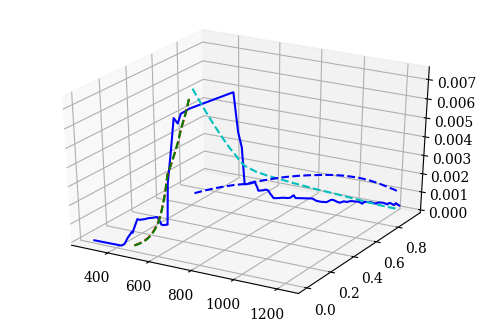

In [ ]:
#se capturan los index de los dos mejores modelos
i_mejor_modelo_E1=int(resultadosE1[['BIC']].idxmin())
i_segundo_mejor_E1=resultadosE1['BIC'].nsmallest(2).index[1]

#Se calculan los Z de acuerdo con los indices de los 2 mejores modelos
Z_mejor_modelo_E1 = modelos[i_mejor_modelo_E1](X1,Y1,A1[i_mejor_modelo_E1],E1[i_mejor_modelo_E1])
Z_segundo_mejor_E1 = modelos[i_segundo_mejor_E1](X1,Y1,A1[i_segundo_mejor_E1],E1[i_segundo_mejor_E1])

plt.figure(dpi=100)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(X, Y, Z, 'blue')

ax.plot3D(X1,Y1,Z_mejor_modelo_E1,"r--")

ax.plot3D(X1,Y1,Z_segundo_mejor_E1,'g--')



#se grafican el primer y segundo mejores modelos
i_mejor_modelo_E2=int(resultadosE2[['BIC']].idxmin())
i_segundo_mejor_E2=resultadosE2['BIC'].nsmallest(2).index[1]

Z_mejor_modelo_E2 = modelos[i_mejor_modelo_E2](X2,Y2,A2[i_mejor_modelo_E2],E2[i_mejor_modelo_E2])
Z_segundo_mejor_E2=modelos[i_segundo_mejor_E2](X2,Y2,A2[i_segundo_mejor_E2],E2[i_segundo_mejor_E2])
ax.plot3D(X2,Y2,Z_mejor_modelo_E2,'c--')
ax.plot3D(X2,Y2,Z_segundo_mejor_E2,'b--')


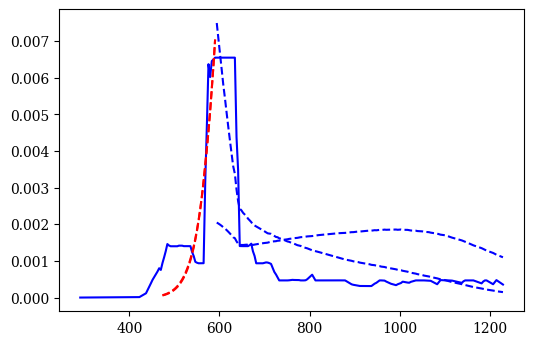

In [ ]:
plt.figure(dpi=100)
ax = plt.axes()

ax.plot(X,Z,"blue")

ax.plot(X1,Z_mejor_modelo_E1,"--r")
ax.plot(X2,Z_mejor_modelo_E2,'--b')

ax.plot(X1,Z_segundo_mejor_E1,"--r")
ax.plot(X2,Z_segundo_mejor_E2,'--b')

In [ ]:
def DefinirEA(resultados):
  #Modelos con E y A que cambian
  def D1ED(a,T):
    E=resultados['E (KJ/mol)'][0]
    A=resultados['A'][0]
    dydt=(A/10)*np.exp(-E/(0.0083144*(T)))*1/(2*a)
    return dydt

  def D2ED(a,T):
    E=resultados['E (KJ/mol)'][1]
    A=resultados['A'][1]
    dydt=(A/10)*np.exp(-E/(0.0083144*(T)))*(2*(1-a)**(2/3))/(1-(1-a)**(1/3))
    return dydt
  def R1ED(a,T):
    E=resultados['E (KJ/mol)'][2]
    A=resultados['A'][2]
    dydt=(A/10)*np.exp(-E/(0.0083144*(T)))*(1-a)
    return dydt

  def R2ED(a,T):
    E=float(resultados['E (KJ/mol)'][3])
    A=resultados['A'][3]
    dydt=(A/10)*np.exp(-E/(0.0083144*(T)))*(1-a)**2
    return dydt

  def C1ED(a,T):
    E=resultados['E (KJ/mol)'][4]
    A=resultados['A'][4]
    dydt=(A/10)*np.exp(-E/(0.0083144*(T)))*2*(1-a)**(1/2)
    return dydt

  def C2ED(a,T):
    E=resultados['E (KJ/mol)'][5]
    A=resultados['A'][5]
    dydt=(A/10)*np.exp(-E/(0.0083144*(T)))*3*(1-a)**(2/3)
    return dydt
  modelosEEDD=[D1ED,D2ED,R1ED,R2ED,C1ED,C2ED]
  return modelosEEDD


In [ ]:
#Funcion que resuelve la ecuacion diferencial con el modelo deseado

def resolverEEDD(modelo,datos):
  '''Entra el modelo como una funcion y los datos con columnas en orden: T(K), a, da/dT'''
  # initial condition first part
  a0 =datos.iloc[0,1] 

  # Temperature points
  T=datos["T (K)"]

  # solve ODE
  acalculado = odeint(modelo,a0,T)

  #Compute R2

  r2 = r2_score(datos["a"], acalculado)

  
  return acalculado, r2

In [ ]:
#Resolucion de la ecuacion diferencial con los parametros calculados anteriormente--ETAPA I
modelosEEDD=DefinirEA(resultadosE1)
#Inicializacion de los valores de a calculados y de R2
a_E1=[]
r21=[]
for elemento in modelosEEDD:
  try:
    a_E,r2=resolverEEDD(elemento,datosE1)
    r21.append(r2)
    a_E1.append(a_E)
  except:
    r21.append('0')
    a_E1.append(np.zeros(len(X1)))
resultadosE1['R2 Ec. integrada']=r21
chi1=[]
#calculo de chisquare
resultadosE1

,Modelo,E (KJ/mol),A,BIC,R2 Ec. integrada
0,D1,168.886118,3.662658e+13,-440.712996,0.632854
1,D2,192.308572,5.063178e+14,-440.213593,0.578403
2,R1,107.564419,3.258134e+08,-443.958324,0.491478
3,R2,130.383991,4.802524e+10,-442.910591,0.407789
4,C1,96.609170,1.472678e+07,-444.628112,0.542559
5,C2,100.207901,2.163820e+07,-444.393732,0.525033


In [ ]:
#Resolucion de la ecuacion diferencial con los parametros calculados anteriormente--ETAPA II
modelosEEDD=DefinirEA(resultadosE2)
#Inicializacion de los valores de a calculados y de R2
a_E2=[]
r22=[]
for elemento in modelosEEDD:
  try: 
    a_E,r2=resolverEEDD(elemento,datosE2)
    r22.append(r2)
    a_E2.append(a_E)
  except:
    r22.append('0')
    a_E2.append('0')

resultadosE2['R2 Ec. integrada']=r22
i_mejor_modeloE1=resultadosE2
resultadosE2

,Modelo,E (KJ/mol),A,BIC,R2 Ec. integrada
0,D1,38.698876,1.0,-1342.430737,-4.684174
1,D2,36.355484,1.0,-1352.837118,-0.336634
2,R1,17.380938,1.0,-1382.782644,0.330310
3,R2,9.150756,1.0,-1554.131239,0.899639
4,C1,39.475489,1.0,-1342.941931,-4.300954
5,C2,38.701482,1.0,-1343.899526,-3.188653


In [ ]:
resultados=[]
resultados=pd.concat([resultadosE1,resultadosE2],axis=0)
resultados

,Modelo,E (KJ/mol),A,BIC,R2 Ec. integrada
0,D1,168.886118,3.662658e+13,-440.712996,0.632854
1,D2,192.308572,5.063178e+14,-440.213593,0.578403
2,R1,107.564419,3.258134e+08,-443.958324,0.491478
3,R2,130.383991,4.802524e+10,-442.910591,0.407789
4,C1,96.609170,1.472678e+07,-444.628112,0.542559
5,C2,100.207901,2.163820e+07,-444.393732,0.525033
0,D1,38.698876,1.000000e+00,-1342.430737,-4.684174
1,D2,36.355484,1.000000e+00,-1352.837118,-0.336634
2,R1,17.380938,1.000000e+00,-1382.782644,0.330310
3,R2,9.150756,1.000000e+00,-1554.131239,0.899639


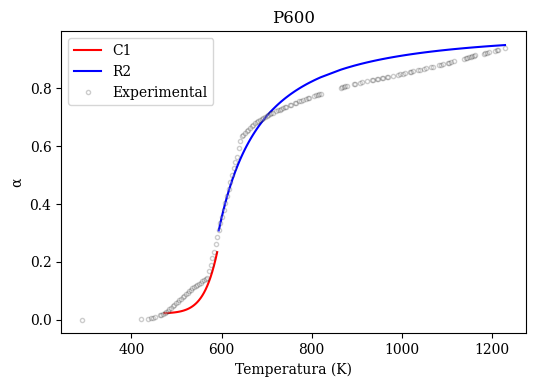

In [ ]:

# plot results
plt.figure(dpi=100)
plt.rcParams["font.family"] = "serif"
plt.plot(X1,a_E1[i_mejor_modelo_E1],"r",label=resultadosE1['Modelo'][i_mejor_modelo_E1])
#plt.plot(X1,a_E1[2],"c",label=resultadosE1['Modelo'][2])
plt.plot(X2,a_E2[i_mejor_modelo_E2],"b",label=resultadosE2['Modelo'][i_mejor_modelo_E2])

#plt.plot(X2,a_E2[5],"c",label=resultadosE2['Modelo'][5])



plt.plot(datos["T (K)"],datos["a"],"o",markersize=3, linewidth=0.1,markerfacecolor='white', markeredgecolor='black',alpha=0.2,label="Experimental")
plt.xlabel('Temperatura (K)')
plt.ylabel('α')
plt.legend()
plt.title('P1200')
plt.savefig("resultado.png")